# Introduction

In this series of tutorials, the fundamental aspects of a BigDFT calculation are inspected.

The **topics** addressed are:
- building a system
- running a simple calculation
- reading a Logfile

Those subjects are then each followed by **exercises**.

The **prerequisites** are:
- beginner level in python programming (1)
- understanding of *ab initio* methods (2)

In the following, PyBigDFT is used to build systems and then compute their first-principles properties using BigDFT.

The code packages are installed through the following

In [ ]:
install = "client (Google drive)" #@param ["full_suite", "client (Google drive)", "client"]
install_var=install
!wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/packaging/install.py &> /dev/null
args={'locally': True} if install == 'client' else {}
import install
getattr(install,install_var.split()[0])(**args)

For this part of the tutorial we have to install an extra package.
If your client installation is performed on the google drive, such command will not be needed in the future.


In [ ]:
install.packages('py3Dmol')

## Python intrinsics manipulation

In python, two datastructures are very common: **lists** and **dictionaries**.

In [4]:
my_list = [0, 1, 2, 3]
print(my_list[-1])
my_dict = {"a": "word", "c": 4}
print(my_dict["c"])

3
4


Those objects are easily built and manipulated using comprehensions

In [5]:
my_list2 = [x*3 for x in my_list]
print(my_list2)
my_dict2 = {k+"2": v for k,v in my_dict.items()}
print(my_dict2)

[0, 3, 6, 9]
{'a2': 'word', 'c2': 4}


Additionally, those objects are serializable in yaml format for improved readability

In [6]:
from yaml import dump

print(dump(my_dict2))

a2: word
c2: 4



## What we mean with *ab initio* methods?

Ab initio quantum chemistry methods attempt to solve Schrödinger's equation given the **positions** of the nuclei and the **number of electrons**, yielding useful information such as electron densities, energies and other properties of the system.

A first-principles calculation therefore requires:
- a geometry (along with a lattice for solid-state)
- an exchange-correlation (XC) functional
- a set of input parameters which are specific of the numerical treatment of the method

# The Geometry: Building a system

In PyBigDFT, geometries are build upon different layers:
- Atoms: stores any information (dict)
- Fragments: are collection of Atoms (list)
- Systems: are collection of Fragments (dict)

## Atoms

Any system is composed of atoms, which require both a **symbol** and a **position**. 

The most appropriate way to store such information (or any other) about an atom is inside a `dict`

In [7]:
at = {"sym": "H", "r": [1, 0, 0], "units": "angstroem"}
print(dump(at))

r:
- 1
- 0
- 0
sym: H
units: angstroem



The `Atoms` class wraps up `dict` in order to provide helpful subroutines.

In [8]:
from BigDFT.Atoms import Atom

atom = Atom(at)
print(dump(atom))

!!python/object:BigDFT.Atoms.Atom
store:
  r:
  - 1
  - 0
  - 0
  sym: H
  units: angstroem



Some of the built in subroutines are demonstrated below.

In [9]:
print(atom.sym)
print(atom.atomic_number)
print(atom.get_position("angstroem"))
print(atom.get_position("bohr"))

H
1
[1.0, 0.0, 0.0]
[1.8897261245650618, 0.0, 0.0]


With this approach, the flexibility of a `dict` is retained.

In [10]:
atom["source"] = "tutorial"
print(atom["source"])
for k,v in atom.items():
    print(k,v)

tutorial
sym H
r [1, 0, 0]
units angstroem
source tutorial


## Fragments

Calculations involve not single atoms but instead **groups of atoms**. In this case, lists are used as model data structures, with the wrapper class referred to as a `Fragment`. 

In [11]:
at1 = Atom({"sym": "O", "r": [2.3229430273, 1.3229430273, 1.7139430273], "units": "angstroem"})
at2 = Atom({"sym": "H", "r": [2.3229430273, 2.0801430273, 1.1274430273], "units": "angstroem"})
at3 = Atom({"sym": "H", "r": [2.3229430273, 0.5657430273000001, 1.1274430273], "units": "angstroem"})

In [12]:
from BigDFT.Fragments import Fragment

frag1 = Fragment([at1, at2, at3])
print(len(frag1))
print(frag1.centroid)

3
[4.38972612 2.5        2.5       ]


It's also possible to build up a fragment in a more step by step process.

In [13]:
frag1 = Fragment()
frag1.append(at1)
frag1 += Fragment([at2])
frag1.extend(Fragment([at3]))

The fragment properties are then visualized in yaml format

In [14]:
print(dump(frag1))

!!python/object:BigDFT.Fragments.Fragment
atoms:
- !!python/object:BigDFT.Atoms.Atom
  store:
    r:
    - 2.3229430273
    - 1.3229430273
    - 1.7139430273
    sym: O
    units: angstroem
- !!python/object:BigDFT.Atoms.Atom
  store:
    r:
    - 2.3229430273
    - 2.0801430273
    - 1.1274430273
    sym: H
    units: angstroem
- !!python/object:BigDFT.Atoms.Atom
  store:
    r:
    - 2.3229430273
    - 0.5657430273000001
    - 1.1274430273
    sym: H
    units: angstroem
conmat: null
frozen: null
q1: null
q2: null



## Systems

In PyBigDFT, we have the `System` class at the top, based on a `dict`.
Systems are **named collections of fragments**, with the convention for naming fragments as "NAME:ID" (where name is a string and ID is a number).

In [15]:
from BigDFT.Systems import System

sys = System()
sys["WAT:0"] = frag1

Similarly, systems are easily readable

In [16]:
print(dump(sys))

!!python/object:BigDFT.Systems.System
cell: !!python/object:BigDFT.UnitCells.UnitCell
  cell:
  - - .inf
    - 0
    - 0
  - - 0
    - .inf
    - 0
  - - 0
    - 0
    - .inf
conmat: null
store:
  WAT:0: !!python/object:BigDFT.Fragments.Fragment
    atoms:
    - !!python/object:BigDFT.Atoms.Atom
      store:
        r:
        - 2.3229430273
        - 1.3229430273
        - 1.7139430273
        sym: O
        units: angstroem
    - !!python/object:BigDFT.Atoms.Atom
      store:
        r:
        - 2.3229430273
        - 2.0801430273
        - 1.1274430273
        sym: H
        units: angstroem
    - !!python/object:BigDFT.Atoms.Atom
      store:
        r:
        - 2.3229430273
        - 0.5657430273000001
        - 1.1274430273
        sym: H
        units: angstroem
    conmat: null
    frozen: null
    q1: null
    q2: null



Additional properties can also be displayed, like the **connectivity matrix** and the **unit cell**.

## System visualization and fragments manipulation

It is extremely convenient to visualize `System` objects, just do

In [17]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

It is equally convenient to manipulate fragments within systems.

Let us **rotate** and **translate** the previous water fragment and add it to the system.

In [18]:
from copy import deepcopy

frag2 = deepcopy(frag1)
frag2.translate([10, 0, 0])
frag2.rotate(x=90, units="degrees")
sys["WAT:1"] = frag2

In [19]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The visualization module has identified that there are two separate fragments, coloring them accordingly (merging fragments would render a uniform visualization).

To summarize the hierarchy, let's iterate over our `System`.

In [20]:
for fragid, frag in sys.items():
    print(fragid)
    for atm in frag:
        print(dict(atm))

WAT:0
{'sym': 'O', 'r': [2.3229430273, 1.3229430273, 1.7139430273], 'units': 'angstroem'}
{'sym': 'H', 'r': [2.3229430273, 2.0801430273, 1.1274430273], 'units': 'angstroem'}
{'sym': 'H', 'r': [2.3229430273, 0.5657430273000001, 1.1274430273], 'units': 'angstroem'}
WAT:1
{'sym': 'O', 'r': [14.389726124565062, 1.7611170852950608, 2.499999999999999], 'units': 'bohr'}
{'sym': 'H', 'r': [14.389726124565062, 2.86944145735247, 3.930900621520664], 'units': 'bohr'}
{'sym': 'H', 'r': [14.389726124565062, 2.86944145735247, 1.0690993784793343], 'units': 'bohr'}


In [22]:
# atom iteration, if we do not want to keep track of the fragment
for atm in sys.get_atoms():
  print(dict(atm))

{'sym': 'O', 'r': [2.3229430273, 1.3229430273, 1.7139430273], 'units': 'angstroem'}
{'sym': 'H', 'r': [2.3229430273, 2.0801430273, 1.1274430273], 'units': 'angstroem'}
{'sym': 'H', 'r': [2.3229430273, 0.5657430273000001, 1.1274430273], 'units': 'angstroem'}
{'sym': 'O', 'r': [14.389726124565062, 1.7611170852950608, 2.499999999999999], 'units': 'bohr'}
{'sym': 'H', 'r': [14.389726124565062, 2.86944145735247, 3.930900621520664], 'units': 'bohr'}
{'sym': 'H', 'r': [14.389726124565062, 2.86944145735247, 1.0690993784793343], 'units': 'bohr'}


## Solid State Systems

The cell attribute of the `System` object enables to investigate systems ranging from **molecular biology** to **condensed matter physics**, by fixing the periodic boundaries conditions. 

The `UnitCell` class is available to manage the cell.

In [23]:
from BigDFT.UnitCells import UnitCell

sys.cell = UnitCell([5, 5, 5], units="bohr")

In [24]:
print(sys.cell.get_posinp())

[5.0, 5.0, 5.0]


BigDFT is able to handle several boundary conditions, depending on the cell. 
- if set to `None`: free boundary
- if $x$ and $y$ are set to `inf`: 1D system 
- if $y$ is set to `inf`: 2D periodic system (note that $y$ direction is free)
- if all values are `float`: 3D periodic system.

For wire boundary conditions

In [25]:
sys.cell = UnitCell([float("inf"), float("inf"), 5], units="bohr")
print(sys.cell.get_posinp("bohr"))

[inf, inf, 5.0]


For the surface condition

In [26]:
sys.cell = UnitCell([5, float("inf"), 5], units="bohr")
print(sys.cell.get_posinp("bohr"))

[5.0, inf, 5.0]


Note that **reduced** (fractional) coordinates can be employed to alternatively specify the locations of atoms (*for fully periodic boundary conditions*).

In [27]:
cell = UnitCell([10, 10, 10], units="bohr")

In [28]:
at = Atom({'r': [0.5, 0.25, 0.0], 'sym': "He", 'units': 'reduced'})

print(at.get_position("reduced", cell))
print(at.get_position("bohr", cell))
print(at.get_position("angstroem", cell))

[0.5, 0.25, 0.0]
[5.0, 2.5, 0.0]
[2.6458860546, 1.3229430273, 0.0]


## File I/O

A wide range of standard files can easily be manipulated with PyBigDFT.

### XYZ Files

The `XYZReader` class enables to access the some built in molecules in the database (available [here](https://gitlab.com/l_sim/bigdft-suite/-/tree/devel/PyBigDFT/BigDFT/Database/XYZs)). Otherwise, a path for the filename is required.

In [29]:
from BigDFT.IO import XYZReader

sys = System()
sys["CH4:0"] = Fragment()
with XYZReader("CH4") as ifile:
    for atom in ifile:
        sys["CH4:0"].append(atom)
        
sys["CH2F:1"] = Fragment()
with XYZReader("CH2F") as ifile:
    for atom in ifile:
        sys["CH2F:1"].append(atom)
        
sys["CH2F:1"].translate([-5, 0, 0])

The resulting system is

In [30]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Afterwards, the `XYZWriter` class enables to write down our data in the `xyz` format.

In [31]:
from BigDFT.IO import XYZWriter

natoms = sum([len(x) for x in sys.values()])
with XYZWriter("sys.xyz", natoms=natoms) as ofile:
    for frag in sys.values():
        for at in frag:
            ofile.write(at)

Or, similarly

In [32]:
from BigDFT import IO

with open('sys.xyz','w') as infile:
    IO.write_xyz(sys,infile)

The advantage of the `XYZreader` (or `XYZwriter`) approach is to directly yield the following attributes: `units`, `natoms` and `cell`. 

Warning: when reading an `xyz` file, **there is no fragment information available**

The system is either defined as one fragment (`single`) or each atoms are a single fragment (`atomic`)

**Important**: from the point of view of the BigDFT code, the only important thing is the position of the atoms. The distribution of a system into fragment can be useful for building and (especially) for post-processing purposes. The code will not care about two different fragmentations if the atomic positions are the same.

In [33]:
with open('sys.xyz','r') as ifile:
    sys_a = IO.read_xyz(ifile,fragmentation="single")
sys_a.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [35]:
with open('sys.xyz','r') as ifile:
    sys_b = IO.read_xyz(ifile,fragmentation="atomic")
sys_b.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Other Formats

Similarly to `xyz` files, let us write a PDB file (for example).

In [36]:
with open('sys.pdb', 'w') as ofile:
    IO.write_pdb(sys, ofile)

Let us then inspect this pdb file

In [37]:
with open('sys.pdb','r') as ifile:
    for line in ifile:
        print(line, end="")

HETATM    1 C    CH4 A   0       0.000   0.000   0.000  1.00  0.00       B   C  
HETATM    2 H    CH4 A   0       0.628   0.628   0.628  1.00  0.00       B   H  
HETATM    3 H    CH4 A   0       0.628  -0.628  -0.628  1.00  0.00       B   H  
HETATM    4 H    CH4 A   0      -0.628   0.628  -0.628  1.00  0.00       B   H  
HETATM    5 H    CH4 A   0      -0.628  -0.628   0.628  1.00  0.00       B   H  
HETATM    6 C    CH2 A   1      -2.675   0.655   0.000  1.00  0.00       B   C  
HETATM    7 F    CH2 A   1      -2.675  -0.682   0.000  1.00  0.00       B   F  
HETATM    8 H    CH2 A   1      -2.431   1.104   0.947  1.00  0.00       B   H  
HETATM    9 H    CH2 A   1      -2.431   1.104  -0.947  1.00  0.00       B   H  


Of course, a pdb system is also readable

In [38]:
for fragid, frag in IO.read_pdb(open('sys.pdb','r')).items():
    print(fragid)
    for at in frag:
        print(dict(at))

CH4:0
{'sym': 'C', 'r': [0.0, 0.0, 0.0], 'name': 'C', 'units': 'angstroem'}
{'sym': 'H', 'r': [0.628, 0.628, 0.628], 'name': 'H', 'units': 'angstroem'}
{'sym': 'H', 'r': [0.628, -0.628, -0.628], 'name': 'H', 'units': 'angstroem'}
{'sym': 'H', 'r': [-0.628, 0.628, -0.628], 'name': 'H', 'units': 'angstroem'}
{'sym': 'H', 'r': [-0.628, -0.628, 0.628], 'name': 'H', 'units': 'angstroem'}
CH2:1
{'sym': 'C', 'r': [-2.675, 0.655, 0.0], 'name': 'C', 'units': 'angstroem'}
{'sym': 'F', 'r': [-2.675, -0.682, 0.0], 'name': 'F', 'units': 'angstroem'}
{'sym': 'H', 'r': [-2.431, 1.104, 0.947], 'name': 'H', 'units': 'angstroem'}
{'sym': 'H', 'r': [-2.431, 1.104, -0.947], 'name': 'H', 'units': 'angstroem'}


Notice how the **information on fragments is conserved** 

## Exercises on systems 

1) Construct a complex of C2H4 molecules, arranged in a equilateral triangle, using the molecule database.

2) Construct a carbon chain of inter-atomic distance of 1.5 angstroem.

3) Construct a graphene lattice using a rectangular cell and a carbon-carbon bond of 1.42 angstroem. (**Advanced**)

# A first-principles calculation : Nitrogen molecule

Let us go through the fundamentals of simple BigDFT calculation.

The following parameters need to addressed one by one:
- the atomic positions
- the exchange-correlation functional
- the proper converged parameters

For this part of the tutorial, it is interesting to install the full suite, as some calculations can be performed live.

In [ ]:

install = "full_suite" #@param ["full_suite", "client (Google drive)", "client"]
install_var=install
!wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/packaging/install.py &> /dev/null
args={'locally': True} if install == 'client' else {}
import install
getattr(install,install_var.split()[0])(**args)

In [1]:
import install
install.set_ready()

Executing: mkdir -p /content/bigdft-school



In [ ]:
# we need some data to be installed also
install.data('data/session1.tar.xz')

## How to perform a first run 

Atomic positions can be obtained from the BigDFT database (available [here](https://gitlab.com/l_sim/bigdft-suite/-/tree/devel/PyBigDFT/BigDFT/Database/XYZs)).

In [3]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from BigDFT.IO import XYZReader

N2 = System()
with XYZReader("N2") as ifile:
    N2["N:0"] = Fragment([next(ifile)])
    N2["N:1"] = Fragment([next(ifile)])

The atomic positions are then

In [4]:
print(N2.get_posinp())

{'positions': [{'N': [0.0, 0.0, 0.5488], 'frag': ['N', '0']}, {'N': [0.0, 0.0, -0.5488], 'frag': ['N', '1']}], 'units': 'angstroem', 'cell': [inf, inf, inf]}


A calculation is run using the `Calculator` class. 

In [7]:
from BigDFT import Calculators as C

study = C.SystemCalculator(verbose=True) #Create a calculator
log = study.run(posinp=N2.get_posinp(),name="N2",run_dir='scratch') #run the code

Initialize a Calculator with OMP_NUM_THREADS=1 and command bigdft
Creating the yaml input file "scratch/default.yaml"
Run directory scratch
Executing command:  bigdft -n N2


An instance of the `Logfile` class is returned, containing information about the electronic structure (and more) of the system.

For example, the total energy of the system is

In [6]:
log.energy #this value is in Ha

-19.884615273242606

Similarly, the eigenvalues and the DoS are obtained as

In [8]:
log.evals[0].tolist() # the eigenvalues in Ha ([0] stands for the first K-point, here meaningless)

[[-1.041353673208,
  -0.4926440819324,
  -0.4357815638016,
  -0.4357812404171,
  -0.3818323179544]]

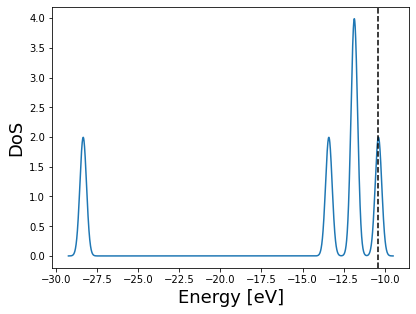

In [9]:
log.get_dos().plot(); #the density of states

### Calculators

let us look closer at the SystemCalculator that was presented above.

In [10]:
# we use very little resources asa we are in the cloud.
calc = C.SystemCalculator(verbose=False,omp=2,mpi_run='mpirun --allow-run-as-root -np 1')

This allows to set the computational parameters such as the OpenMP and MPI parallelisations, which is of **crucial importance** for memory and time efficiency. 

**Important**: this tutorial is not representative of the actual time spent in running the code. Here we are using google Colab resources and therfore

The global options of the runner (or calculator) can then be accessed by

In [11]:
calc.global_options()

{'omp': '2',
 'mpi_run': 'mpirun --allow-run-as-root -np 1',
 'dry_run': False,
 'skip': False,
 'verbose': False}

### RemoteRunner

Note that PyBigDFT also enables to run workflows remotely, as explained in this [tutorial](../tutorials/RemoteRunner.ipynb).

## How to modify the input parameters

To specify non-default input parameters to the code, we should employ a `Inputfile` object.

For instance, the XC functional can be chosen via the `set_xc` method.
All methods are accessible [here](https://l_sim.gitlab.io/bigdft-suite/PyBigDFT/build/html/BigDFT.InputActions.html)

In [12]:
from BigDFT import Inputfiles as I

inp = I.Inputfile()
inp.set_xc('LDA')

In the same spirit, a Hartree-Fock calculation is performed using.

In [14]:
inp.set_xc('HF')
HF = study.run(name="HF",input=inp,run_dir='scratch') #Run the code with the name scheme HF

Creating the yaml input file "scratch/HF.yaml"
Run directory scratch
Executing command:  bigdft -n HF
ERROR: some problem occured during the execution of the command, check the 'debug/' directory and the logfile
The error occured is BIGDFT_INPUT_FILE_ERROR
Additional Info:  The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found for "N"


An **error** occurred !

Let us identify the issue by opening [debug/bigdft-err-0.yaml](./debug/bigdft-err-0.yaml)

<pre>
 Additional Info:
   The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found 
   for "N"</pre>
   
The issue is that the pseudopotential is assigned by default in the code **only for LDA and PBE** XC approximations.

Therefore, one simply needs to specify it.

In [16]:
inp['psppar.N']={'Pseudopotential XC': 1} #here 1 stands for LDA as per the XC codes
study.update_global_options(skip=True) #if a finalized calculation is found in scratch, the calculation is not performed
HF = study.run(name="HF",input=inp,run_dir='scratch')

Creating the yaml input file "scratch/HF.yaml"
Run directory scratch
Executing command:  bigdft -n HF -s Yes


One should be careful in **choosing a pseudopotential** which has been **generated with the same XC approximation** used. 

At present, Hartwigsen-Goedeker-Hutter (HGH) data are unfortunately only available for semilocal functionals. For example, the same exercise as follows could have been done with Hybrid XC functionals (e.g. PBE0 (ixc=-406)). 

In the case of Hartree-Fock calculations, using semilocal functionals generally yield accurate results (see [Physical Review B 37.5 (1988): 2674](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.37.2674)). 

In BigDFT, XC functionals are specified using the built in named functionals, or using the [LibXC codes](https://www.tddft.org/programs/libxc/functionals/).

## How to perform a convergence analysis

Daubechies Wavelets is a systematic basis set (as plane waves are), where accuracy is arbitrarily increased by varying some parameters, i.e. (typically) `hgrid` and `rmult`.

**`hgrids`**
      set up the grid step for the basis set spatial expansion. There is **one float value** describing the grid         steps in the three space directions (i.e. $x$, $y$ and $z$) or a **3D array** is also accepted.
      These values are in bohr unit and typically range from 0.3 to 0.65. 
      The harder the pseudo-potential, the lower value should be set up.
      These values are set using the `set_hgrid` method of the `Inpufile` class.
        
**`rmult`**
      set up the basis set spatial expansion. It contains an array of two float values that are **two multiplying       factors** defining chemical-species-dependent quantities.
      The first factor is the most important since it describes the spatial expansion of the basis set, defined as       a set of real space points with non-zero values inside spheres centered on atoms.
      The first multiplying factor is called `crmult` for Coarse grid Radius MULTiplier, with typical values of 5       to 7.
      The second one called `frmult` for Fine grid Radius MULTiplier is related to the fine resolution.
      This parameter is less pertinent for the convergence of energy and can be ignored.
      It is possible to indicate only one float value, the `crmult` parameter.
      Such parameters can be set by the method `set_rmult` of `Inputfile` class.

Let us find the appropriate parameters to characterize a N2 molecule using the `Dataset`class, by comparing the extracted energies depending on `hgrid` and `rmult`.

In [17]:
hgrids = [0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2] #bohr
rmult = [3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

Let us build three different datasets, by varying:
- `hgrid` and `rmult` together. 
- only `hgrid`
- only `rmult`

Each input dictionary is also labeled by a unique name.

In [23]:
from BigDFT import Datasets as D
from copy import deepcopy

inp = I.Inputfile()
pos = N2.get_posinp()
study = C.SystemCalculator(verbose=True, skip=True) #to avoid long waiting time

h_and_c_dataset = D.Dataset('h_and_c')
for h,c in zip(hgrids,rmult):
    inp_run = deepcopy(inp) # to avoid modifications of `inp`
    inp_run.set_hgrid(h)
    inp_run.set_rmult([c,9.0])
    h_and_c_dataset.append_run(id={'h':h,'c':c},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Initialize a Calculator with OMP_NUM_THREADS=1 and command bigdft


In [24]:
h_only_dataset = D.Dataset('h_only')
for h in hgrids:
    inp_run = deepcopy(inp)
    inp_run.set_hgrid(h)
    h_only_dataset.append_run(id={'h':h},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

In [25]:
c_only_dataset = D.Dataset('c_only')
for c in rmult:
    inp_run = deepcopy(inp)
    inp_run.set_rmult([c,9.0])
    c_only_dataset.append_run(id={'c':c},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Each dataset is then ran. This cell, when executed with the full_suite, should take about 6-7 minutes to complete. While this is running, you can proceed with the following tutorial which can be executed in `dry_run` scheme (namely without actually running the computations).

In [26]:
h_only_dataset.run()
c_only_dataset.run()
h_and_c_dataset.run()

Creating the yaml input file "scratch/h__0.55.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.55 -s Yes
Creating the yaml input file "scratch/h__0.5.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.5 -s Yes
Creating the yaml input file "scratch/h__0.45.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.45 -s Yes
Creating the yaml input file "scratch/h__0.4.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.4 -s Yes
Creating the yaml input file "scratch/h__0.35.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.35 -s Yes
Creating the yaml input file "scratch/h__0.3.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.3 -s Yes
Creating the yaml input file "scratch/h__0.25.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.25 -s Yes
Creating the yaml input file "scratch/h__0.2.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.2 -s Yes
Creating the yaml input file "scratch/c__3.5.yaml"
Run d

{0: <BigDFT.Logfiles.Logfile at 0x7f9796ec4ed0>,
 1: <BigDFT.Logfiles.Logfile at 0x7f9796cb6cd0>,
 2: <BigDFT.Logfiles.Logfile at 0x7f9796d4e710>,
 3: <BigDFT.Logfiles.Logfile at 0x7f9796bcfa90>,
 4: <BigDFT.Logfiles.Logfile at 0x7f97995db050>,
 5: <BigDFT.Logfiles.Logfile at 0x7f9796ee4590>,
 6: <BigDFT.Logfiles.Logfile at 0x7f9796bbf110>,
 7: <BigDFT.Logfiles.Logfile at 0x7f9796c0dad0>}

We now store the energies of each of the dataset runs, and identify the minimum as the minimum value from the `h_and_c` dataset:

In [29]:
from numpy import array

energies_h = array(h_only_dataset.fetch_results(attribute='energy'))
energies_c = array(c_only_dataset.fetch_results(attribute='energy'))
energies_hc = array(h_and_c_dataset.fetch_results(attribute='energy'))
#find the minimum and subtract (do you understand numpy syntax? Otherwise don't be afraid to ask...)
emin = min(energies_hc)
h_data=energies_h-emin
c_data=energies_c-emin
h_and_c_data=energies_hc-emin

We plot the energy values varying the grid spacing or the wavelet extension

In [27]:
h_and_c_dataset.ids

[{'h': 0.55, 'c': 3.5},
 {'h': 0.5, 'c': 4.0},
 {'h': 0.45, 'c': 4.5},
 {'h': 0.4, 'c': 5.0},
 {'h': 0.35, 'c': 5.5},
 {'h': 0.3, 'c': 6.0},
 {'h': 0.25, 'c': 6.5},
 {'h': 0.2, 'c': 7.0}]

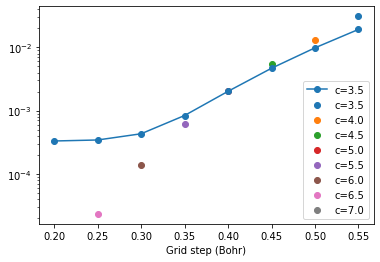

In [41]:
import matplotlib.pyplot as plt

plt.xlabel('Grid step (Bohr)')
plt.yscale('log')
plt.plot(hgrids,h_data,label='c=3.5',marker='o',linestyle='solid')
for dt,e in zip(h_and_c_dataset.ids,h_and_c_data):
    x=dt['h']
    plt.scatter(x,e,label='c='+str(dt['c']))
plt.legend(loc='best');

Likewise, we plot the energy values for the grid spacing

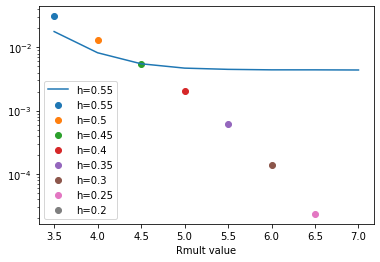

In [42]:
plt.xlabel('Rmult value')
plt.plot(rmult,c_data,label='h=0.55')
for dt,e in zip(h_and_c_dataset.ids,h_and_c_data):
    x=dt['c']
    plt.scatter(x,e,label='h='+str(dt['h']))
plt.yscale('log')
plt.legend(loc='best');

Importantly, both hgrids and rmult have to be decreased and increased (respectively) in order to achieve convergence. Increasing only one of the two parameter will eventually lead to **saturation of the absolute error** on the energy.

### Exercise on XC functional

Compare the values of the HOMO and HOMO-1 eigenvalues for the LDA, PBE, HF and PBE0 functionals. The corresponding outputs are already available in the directory `scratch`, therefore you may run them in skip mode.

The calculation were run with `hgrid=.3` and `rmult=6` using the `Dataset` class, as detailed below.  

**Hint**: the attributes of a `Logfile` object are listed [here](https://l_sim.gitlab.io/bigdft-suite/PyBigDFT/build/html/_modules/BigDFT/Logfiles.html#get_logs). The followin totorial will also explain some tips.

In [43]:
xc_list = ['LDA','PBE','HF','PBE0']

In [44]:
from BigDFT import Datasets as D

inp = I.Inputfile()
inp.set_hgrid(.3)
inp.set_rmult(6)
pos = N2.get_posinp()
study = C.SystemCalculator(skip=True,verbose=True)

xc_dataset = D.Dataset('xc')
for xc in xc_list:
    inp_run = deepcopy(inp)
    inp_run.set_xc(xc)
    if xc in ['HF','PBE0']:
        inp_run['psppar.N']={'Pseudopotential XC': 1} 
    xc_dataset.append_run(id={'xc':xc},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Initialize a Calculator with OMP_NUM_THREADS=1 and command bigdft


In [47]:
xc_dataset.run() #if you run this in skip=False mode you'll need about 6 minutes in Colab cloud resources.

Creating the yaml input file "scratch/xc__LDA.yaml"
Run directory scratch
Executing command:  bigdft -n xc__LDA -s Yes
Creating the yaml input file "scratch/xc__PBE.yaml"
Run directory scratch
Executing command:  bigdft -n xc__PBE -s Yes
Creating the yaml input file "scratch/xc__HF.yaml"
Run directory scratch
Executing command:  bigdft -n xc__HF -s Yes
Creating the yaml input file "scratch/xc__PBE0.yaml"
Run directory scratch
Executing command:  bigdft -n xc__PBE0 -s Yes


{0: <BigDFT.Logfiles.Logfile at 0x7f9796cd3a90>,
 1: <BigDFT.Logfiles.Logfile at 0x7f9796d97610>,
 2: <BigDFT.Logfiles.Logfile at 0x7f9796d92e50>,
 3: <BigDFT.Logfiles.Logfile at 0x7f9796d92b10>}

### Solution

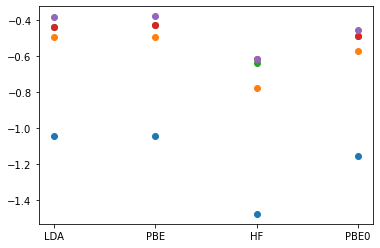

In [48]:
from numpy import array
#this is a qlick look at the difference in evals, possible because we have very few orbitals
evals = array(xc_dataset.fetch_results(attribute='evals'))

plt.plot(xc_list,evals[:,0,0,:],'o');

## Exercise (summary)

1) Compare other attributes of the `Logfile` instance of N2, such as the energy contributions (Hartree, ions, XC, ...), depending on the XC functional

2) Compare the convergence characteristics (`hgrid` and `rmult`) of N2 depending on the XC functional (semilocal vs non-local)

3) Compute the dissociation energies of CH4 (data [here](https://aip.scitation.org/doi/10.1063/1.469843)) (**Advanced**)

# Logfiles analysis

Let us inspect the result of a BigDFT calculation from the `Logfile` class.

An instance is returned after the execution is finished in the form of a `yaml` file, from which the `Logfile` object is extracted.

Let us for example investigate the logfile of the LDA calculation of N2.

In [1]:
install = "client (Google drive)" #@param ["full_suite", "client (Google drive)", "client"]
install_var=install
!wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/packaging/install.py &> /dev/null
args={'locally': True} if install == 'client' else {}
import install
getattr(install,install_var.split()[0])(**args)

Mounted at /content/drive
Executing: mkdir -p /content/drive/MyDrive

Executing: git clone --depth 1 https://github.com/BigDFT-group/bigdft-school
Error Occurred:  
 fatal: destination path 'bigdft-school' already exists and is not an empty directory.

Executing: mkdir -p /content/drive/MyDrive/bigdft-school



In [2]:
from BigDFT import Logfiles as L

logfile = L.Logfile('./scratch/log-xc__LDA.yaml')

From this instance, it is first possible to visualize the associated system

In [3]:
from BigDFT import Systems as S

sys = S.system_from_log(logfile,fragmentation='full')
sys.display();

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The information of the logfile are presented clearly

In [4]:
print(logfile)

- Atom types:
  - N
- cell: Free BC
- number_of_orbitals: 5
- posinp_file: xc__LDA.yaml
- XC_parameter: -20
- grid_spacing: 0.3
- spin_polarization: 1
- total_magn_moment: 0
- system_charge: 0
- rmult: 6
- dipole:
  - -7.546821e-05
  - -7.546821e-05
  - -0.0001150379
- energy: -19.889158366113875
- fermi_level: -0.382575362697
- forcemax: 0.01184049963069
- forcemax_cv: 0.0
- gnrm_cv: 0.0001
- nat: 2
- symmetry: disabled
- No. of KS orbitals:
  - 5



The `yaml` serialization is easily obtainable by calling the `log` attribute, in the form of a `dict`. However, this serialiazation is not particularly useful to visualize the output. Better to refer directly to the logfile.

In [6]:
from yaml import dump
print(dump(logfile.log))

Accumulated memory requirements during principal run stages (MiB.KiB):
  Density Construction: 192.2
  Hamiltonian application: 193.614
  Kernel calculation: 268.641
  Orbitals Orthonormalization: 193.614
  Poisson Solver: 274.794
Atomic Forces (Ha/Bohr):
- N:
  - 0.0
  - -3.388131789017e-21
  - -0.01184049963069
- N:
  - 0.0
  - 3.388131789017e-21
  - 0.01184049963069
Atomic System Properties:
  Boundary Conditions: Free
  Number of Symmetries: 0
  Number of atomic types: 1
  Number of atoms: 2
  Space group: disabled
  Types of atoms:
  - N
Atomic structure:
  Rigid Shift Applied (AU):
  - 8.1
  - 8.1
  - 9.15
  position offset:
  - -8.1
  - -8.1
  - -9.15
  positions:
  - N:
    - 4.286335408
    - 4.286335408
    - 5.39077148
  - N:
    - 4.286335408
    - 4.286335408
    - 4.29317148
  units: angstroem
Average noise forces:
  total: 2.6498158e-05
  x: -1.62783873e-05
  y: -1.62783874e-05
  z: 1.31217602e-05
Basis set definition:
  Coarse and Fine Radii Multipliers:
  - 6.0
  - 6.0

For example, information on the Poisson solver is accessible by

In [7]:
logfile.log["Poisson Solver"]

{'BC': 'Free', 'Box': [139, 139, 153], 'MPI tasks': 1}

Or similarly, the self-consistent field cycle

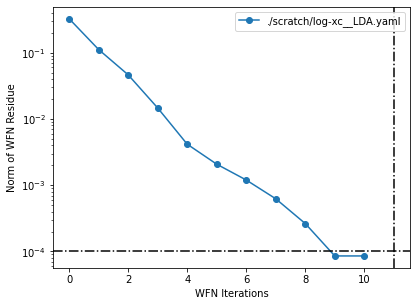

In [15]:
logfile.SCF_convergence()

All `keys` elements are listed afterwards

In [16]:
print(logfile.log.keys())

dict_keys(['Code logo', 'Reference Paper', 'Version Number', 'Timestamp of this run', 'Root process Hostname', 'Number of MPI tasks', 'OpenMP parallelization', 'Maximal OpenMP threads per MPI task', 'Compilation options', 'radical', 'outdir', 'logfile', 'run_from_files', 'skip', 'dft', 'psolver', 'chess', 'output', 'kpt', 'geopt', 'md', 'mix', 'sic', 'tddft', 'mode', 'perf', 'lin_general', 'lin_basis', 'lin_kernel', 'lin_basis_params', 'psppar.N', 'posinp', 'Data Writing directory', 'Atomic System Properties', 'Geometry Optimization Parameters', 'Material acceleration', 'DFT parameters', 'Basis set definition', 'Self-Consistent Cycle Parameters', 'Post Optimization Parameters', 'Properties of atoms in the system', 'Atomic structure', 'Box Grid spacings', 'Sizes of the simulation domain', 'High Res. box is treated separately', 'Wavefunctions Descriptors, full simulation domain', 'Poisson Kernel Initialization', 'Poisson Kernel Creation', 'Total Number of Electrons', 'Spin treatment', 'O

## Extended systems: graphene

Let us inspect a simple example of a solid state calculation by considering a two-dimensional (2D) materials, graphene. 

In [17]:
gr = L.Logfile("./scratch/log-graphene.yaml")

[Graphene](https://en.wikipedia.org/wiki/Graphene) is a 2D carbon allotrope in the form of a honeycomb network that consists of a two inequivalent triangular lattices, with a C-C bond of 1.42$~$angstroem, or equivalently, a lattice parameter such that $a_0 = 2.46~$angstroem.

In [18]:
# or gr.log["Atomic structure"]
gr.astruct

{'units': 'angstroem',
 'cell': [4.330127018922193, inf, 2.5],
 'positions': [{'C': [0.0, 4.127582245, 1.25]},
  {'C': [2.165063509, 4.127582245, 0.0]},
  {'C': [0.7216878365, 4.127582245, 0.0]},
  {'C': [2.886751346, 4.127582245, 1.25]}],
 'position offset': [0.0, -7.8, 0.0],
 'Rigid Shift Applied (AU)': [0.0, 7.8, 0.0],
 'forces': [{'C': [3.725158813391e-05, 0.0, -1.280528231035e-18]},
  {'C': [3.725158813391e-05, 0.0, 2.817162108277e-18]},
  {'C': [-3.725158813391e-05, 0.0, -2.048845169656e-18]},
  {'C': [-3.725158813391e-05, 0.0, -2.048845169656e-18]}]}

In [20]:
# this only visualizes the unit cell atoms
sys = S.system_from_log(gr,fragmentation='full')
sys.display();

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In order to properly characterize extended systems, a $k$-points mesh is required to handle periodicity. 

In [21]:
gr.kpt_mesh

[15, 1, 27]

Additionally, mixing is sometimes needed for convergence, such that the effect of abrupt changes in the density are smoothened away.

In [22]:
print(dump(gr.log["mix"]))
# inp["import"] = "mixing"

alphadiis: 1.d0
alphamix: 0.8
diis_sd_switch_tolerance: 0
iscf: 17
itrpmax: 200
norbsempty: 10
occopt: 1
rpnrm_cv: 1.0e-10
tel: 0.01



The interested reader is invited to go through this [tutorial](../tutorials/SolidState.ipynb)

### Graphene massless Dirac fermions

When analyzing electronic properties, the $k$-dependence is obtained by plotting the band structure. This is done along a given path, that can be specified by the user. 

In [ ]:
install.packages('spglib','ase')

In [28]:
BZ_gr = gr.get_brillouin_zone()

hsp = BZ_gr.special_points # high symmetry points
[print(i) for i in hsp.items()]
paths = BZ_gr.special_paths # high symmetry path list
print(paths)

spacegroup P6/mmm (191)
Lattice found: orthorhombic


/content/drive/MyDrive/bigdft-school/install/lib/python3.7/site-packages/ase/dft/kpoints.py:655: UserWarning: Please call this function with cell as the first argument
  warnings.warn('Please call this function with cell as the first '


irreductible k-points 112
Interpolation bias 1.0852849288836878e-08
('G', array([0., 0., 0.]))
('R', array([0.5, 0.5, 0.5]))
('S', array([0. , 0.5, 0.5]))
('T', array([0.5, 0. , 0.5]))
('U', array([0.5, 0.5, 0. ]))
('X', array([0. , 0.5, 0. ]))
('Y', array([0. , 0. , 0.5]))
('Z', array([0.5, 0. , 0. ]))
[['G', 'X', 'S', 'Y', 'G', 'Z', 'U', 'R', 'T', 'Z'], ['Y', 'T'], ['U', 'X'], ['S', 'R']]


Here we choose half the first path, since the 2D character of our system implies no dependence in $k_x$.

In [29]:
path = paths[0][:5]

Eventually, the band structure is plotted using the `BZ` class by giving a list of special $k$-points (i.e. the `path` defined above)

/content/drive/MyDrive/bigdft-school/install/lib/python3.7/site-packages/ase/dft/kpoints.py:357: UserWarning: Please do not use (kpts, x, X) = bandpath(...).  Use path = bandpath(...) and then kpts = path.kpts and (x, X, labels) = path.get_linear_kpoint_axis().
  warnings.warn('Please do not use (kpts, x, X) = bandpath(...).  '


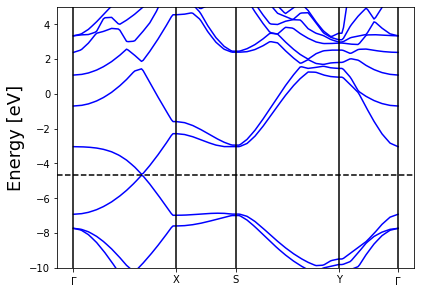

In [30]:
import BigDFT.BZ as BZ

npts = 200
path_bs = BZ.BZPath(BZ_gr.lattice,path,hsp,npts=npts)

ax = BZ_gr.plot(path=path_bs,npts=npts)
ax.set_ylim([-10,5]);

## Exercise on XC functional (suite)

From the previous analysis on XC functionals of N2, compare the following physical or numerical properties:
-  the density of states
-  the wavefunction convergence
-  the memory employed
-  ...

**Hint**: the `Logfile` are obtained with the fetch_results() method

In [31]:
#get the data
install.data('data/session1.tar.xz')

In [44]:
from BigDFT import Datasets as D
from BigDFT import Inputfiles as I
from BigDFT import Calculators as C
from BigDFT.Database import Molecules as M # alternative method to get N2 positions
from copy import deepcopy
inp = I.Inputfile()
inp.set_hgrid(.3)
inp.set_rmult(6)
pos = M.Molecule('N2')
study = C.SystemCalculator(skip=True,verbose=True)
xc_dataset = D.Dataset('xc')
xc_list = ['LDA','PBE','HF','PBE0']
for xc in xc_list:
    inp_run = deepcopy(inp)
    inp_run.set_xc(xc)
    if xc in ['HF','PBE0']:
        inp_run['psppar.N']={'Pseudopotential XC': 1} 
    xc_dataset.append_run(id={'xc':xc},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Initialize a Calculator with OMP_NUM_THREADS=1 and command /content/drive/MyDrive/bigdft-school/install/bin/bigdft


In [45]:
xc_dataset.run()

Creating the yaml input file "scratch/xc__LDA.yaml"
Run directory scratch
Executing command:  /content/drive/MyDrive/bigdft-school/install/bin/bigdft -n xc__LDA -s Yes
Creating the yaml input file "scratch/xc__PBE.yaml"
Run directory scratch
Executing command:  /content/drive/MyDrive/bigdft-school/install/bin/bigdft -n xc__PBE -s Yes
Creating the yaml input file "scratch/xc__HF.yaml"
Run directory scratch
Executing command:  /content/drive/MyDrive/bigdft-school/install/bin/bigdft -n xc__HF -s Yes
Creating the yaml input file "scratch/xc__PBE0.yaml"
Run directory scratch
Executing command:  /content/drive/MyDrive/bigdft-school/install/bin/bigdft -n xc__PBE0 -s Yes


{0: <BigDFT.Logfiles.Logfile at 0x7f815a809910>,
 1: <BigDFT.Logfiles.Logfile at 0x7f8158e21f10>,
 2: <BigDFT.Logfiles.Logfile at 0x7f8158afd950>,
 3: <BigDFT.Logfiles.Logfile at 0x7f8159421950>}

In [46]:
logfiles = xc_dataset.fetch_results()

### Solution

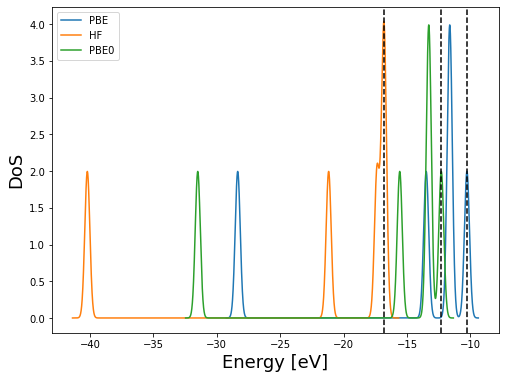

In [51]:
from matplotlib import pyplot as plt, lines
fig,ax = plt.subplots(figsize=(8,6))
for log in logfiles[1:]:
    dos = log.get_dos()
    dos.plot(ax=ax)
colors = ['tab:blue','tab:orange','tab:green']
lins = [lines.Line2D([0],[0],color=c) for c in colors]
ax.legend(lins,xc_list[1:]);

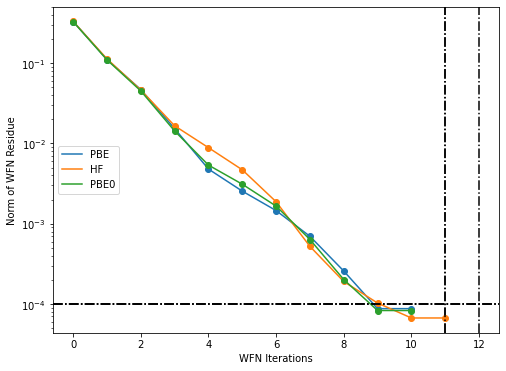

In [52]:
fig,ax = plt.subplots(figsize=(8,6))
for log in logfiles[1:]:
    log.SCF_convergence(ax=ax)
colors = ['tab:blue','tab:orange','tab:green']
lins = [lines.Line2D([0],[0],color=c) for c in colors]
ax.legend(lins,xc_list[1:]);

In [54]:
for log,xc in zip(logfiles,xc_list):
    print(xc,log.log['Estimated Memory Peak (MB)'])

LDA 274
PBE 274
HF 274
PBE0 274
